# Analysis and Simulation of Deep Reliability Data - v0.3

In [1]:
# -- To plot nice!
import matplotlib.pyplot as plt
def putStyle(sFont,syT,top1,R1):
    import matplotlib as mpl
    import matplotlib.style as style

    style.available

    # General plot parameters
    mpl.rcParams['font.family'] = 'Avenir'
    mpl.rcParams['font.size'] = sFont
    mpl.rcParams['axes.linewidth'] = 4
    mpl.rcParams['axes.spines.bottom'] = top1
    mpl.rcParams['axes.spines.right'] = R1
    mpl.rcParams['xtick.major.size'] = 10
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['ytick.major.size'] = 10
    mpl.rcParams['ytick.major.width'] = syT
    mpl.rcParams['lines.linewidth']= 3
    mpl.rcParams["figure.figsize"] = (10,10)
    #mpl.rcParams['axes.title.pad'] = 20
    mpl.rcParams["axes.titlepad"] = 20

---
# Imports for Deep Surv:

In [2]:
# Use DeepSurv from the repo
ds_dir='./'
ds_dir2=ds_dir+'DeepSurv'

import sys, os
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
if os.path.abspath(ds_dir) not in sys.path:
    sys.path.insert(0, os.path.abspath(ds_dir))

In [3]:
# Force matplotlib to not use any Xwindows backend.
import matplotlib
# matplotlib.use('Agg')

import argparse
from collections import defaultdict

import pandas as pd
import numpy as np
import lasagne
import h5py
import uuid
import copy
import json


import DeepSurv.deepsurv.deep_surv as deep_surv
import DeepSurv.deepsurv.viz as viz
import DeepSurv.deepsurv.utils as utils
from DeepSurv.deepsurv.deepsurv_logger import TensorboardLogger

import time
localtime   = time.localtime()
TIMESTRING  = time.strftime("%m%d%Y%M", localtime)


DURATION_COL = 'time'
EVENT_COL = 'censor'

---
# Synthetic dataset with correlation (version 0.3)

In [44]:
from math import log, exp

class SimulatedData:
    def __init__(self, hr_ratio,
        average_use = 5,
        censor_mode = 'end_time',
        end_time = 15, observed_p = None,
        num_features = 10, num_var = 2,
        option_group = False,
        method = 'gaussian'):
        """
        Factory class for producing simulated reliability data.
        Current supports two forms of simulated data:
            Linear:
                Where risk is a linear combination of an observation's features
            Nonlinear (Gaussian):
                A gaussian combination of covariates
        Parameters:
            hr_ratio: lambda_max hazard ratio.
            average_use: average use time that is the mean of the Exponential distribution.
            censor_mode: the method to calculate whether a user is censored.
                Options: ['end_time', 'observed_p']
                'end_time': requires the parameter end_time, which is used to censor any user with use_time > end_time
                'observed_p': requires the parameter observed_p, which is the percentage of users with observed use times
            end_time: censoring time that represents an 'end of study'. Any use time greater than end_time will be censored.
            num_features: size of observation vector. Default: 10.
            num_var: number of variables simulated data depends on. Default: 2.
            option_group: True or False. Include an additional covariate representing a binary option group.
        """

        self.hr_ratio = hr_ratio
        self.censor_mode = censor_mode
        self.end_time = end_time
        self.observed_p = observed_p
        self.average_use = average_use
        self.option_group = option_group
        self.m = int(num_features) + int(option_group)
        self.num_var = num_var
        self.method = method

    def _linear_H(self,x):
        """
        Calculates a linear combination of x's features.
        Coefficients are 1, 2, ..., self.num_var, 0,..0]
        Parameters:
            x: (n,m) numpy array of observations
        Returns:
            risk: the calculated linear risk for a set of data x
        """
        # Make the coefficients [1,2,...,num_var,0,..0]
        b = np.zeros((self.m,))
        b[0:self.num_var] = range(1,self.num_var + 1)

        # Linear Combinations of Coefficients and Covariates
        risk = np.dot(x, b)
        return risk

    def _gaussian_H(self,x,
        c= 0.0, rad= 0.5):
        """
        Calculates the Gaussian function of a subset of x's features.
        Parameters:
            x: (n, m) numpy array of observations.
            c: offset of Gaussian function. Default: 0.0.
            r: Gaussian scale parameter. Default: 0.5.
        Returns:
            risk: the calculated Gaussian risk for a set of data x
        """
        max_hr, min_hr = log(self.hr_ratio), log(1.0 / self.hr_ratio)

        # Z = ( (x_0 - c)^2 + (x_1 - c)^2 + ... + (x_{num_var} - c)^2)
        z = np.square((x - c))
        z = np.sum(z[:,0:self.num_var], axis = -1)

        # Compute Gaussian
        risk = max_hr * (np.exp(-(z) / (2 * rad ** 2)))
        return risk

    def generate_data(self, N,
        method, gaussian_config = {},
        **kwargs):
        """
        Generates a set of observations according to an exponential Cox model.
        Parameters:
            N: the number of observations.
            method: the type of simulated data. 'linear' or 'gaussian'.
            gaussian_config: dictionary of additional parameters for gaussian
                simulation.
        Returns:
            dataset: a dictionary object with the following keys:
                'x' : (N,m) numpy array of observations.
                't' : (N) numpy array of observed time events.
                'e' : (N) numpy array of observed time intervals.
                'hr': (N) numpy array of observed true risk.
        See:
        Peter C Austin. Generating survival times to simulate cox proportional
        hazards models with time-varying covariates. Statistics in medicine,
        31(29):3946-3958, 2012.
        """

        # user Baseline information
        data = np.random.uniform(low= -1, high= 1,
            size = (N,self.m))

        if self.option_group:
            data[:,-1] = np.squeeze(np.random.randint(0,2,(N,1)))
            print(data[:,-1])

        # Each user has a uniform use probability
        p_use = self.average_use * np.ones((N,1))

        # users Hazard Model
        # \lambda(t|X) = \lambda_0(t) exp(H(x))
        #
        # risk = True log hazard ratio
        # log(\lambda(t|X) / \lambda_0(t)) = H(x)
        if method == 'linear':
            risk = self._linear_H(data)

        elif method == 'gaussian':
            risk = self._gaussian_H(data,**gaussian_config)

        # Center the hazard ratio so population leave the use of at the same rate
        # independent of control group (makes the problem easier)
        risk = risk - np.mean(risk)

        # Generate time of use (or attrition from the App) for each user
        # currently exponential random variable
        use_time = np.zeros((N,1))
        for i in range(N):
            if self.option_group and data[i,-1] == 0:
                use_time[i] = np.random.exponential(p_use[i]) #
            else:
                use_time[i] = np.random.exponential(p_use[i]) * 0.01  # ==1, 1% of the ==0

        # If Censor_mode is 'observed_p': then find the end time in which observed_p percent of users have an observed use
        if self.censor_mode == 'observed_p':
            if self.observed_p is None:
                raise ValueError("Parameter observed_p must be provided if censor_mode is configured to 'observed_p'")
            end_time_idx = int(N * self.observed_p)
            self.end_time = np.sort(use_time.flatten())[end_time_idx]

        # Censor anything that is past end time
        censoring = np.ones((N,1))
        # the idea is to have two options in the behaviour of the App...
        censoring[use_time > self.end_time] = 0
        use_time[use_time > self.end_time] = self.end_time

        # Flatten Arrays to Vectors
        use_time = np.squeeze(use_time)
        censoring = np.squeeze(censoring)

        dataset = {
            'x' : data.astype(np.float32),
            'e' : censoring.astype(np.int32),
            't' : use_time.astype(np.float32),
            'hr' : risk.astype(np.float32)
        }

        return dataset

In [45]:
# Simulated data --
# Right now we can include only a Binary options (0 or 1)!
# option_group = True

def sim_data(N,
    method = 'gaussian',
    num_features = 3,
    num_var = 2,
    end_time = 15,
    average_use = 5,
    option_group = False):
    np.random.seed(123)

    # ----
    sd = SimulatedData(
        hr_ratio=2,
        num_features=num_features,
        num_var=num_var,
        end_time=end_time,
        method = method,
        average_use = average_use,
        option_group = option_group,
        )
    train_data = sd.generate_data(N, method)
    valid_data = sd.generate_data(int(N*0.2), method)
    test_data = sd.generate_data(int(N*0.2),  method)

    return train_data, valid_data, test_data

In [46]:
# Function to translate dictionary into Pandas Dataframe
def format_dataset_to_df(dataset, duration_col,
                         event_col, trt_idx = None):
    xdf = pd.DataFrame(dataset['x'])
    if trt_idx is not None:
        xdf = xdf.rename(columns={trt_idx : 'treat'})

    dt = pd.DataFrame(dataset['t'], columns=[duration_col])
    censor = pd.DataFrame(dataset['e'], columns=[event_col])
    risk = pd.DataFrame(dataset['hr'], columns=['hr'])

    cdf = pd.concat([xdf, dt, censor, risk], axis=1)
    return cdf

---
# Simulating data (1)

In [47]:
Nsample = 5000 # 15000
average = 100    # 60
num_features = 4 #
num_var = 2 # 2 # Only Relationship between 2 features.
# linear or gaussian
method = 'linear'
end_time = 100 # ~3 Months...
#option_group = False

# Right now we can include only a Binary treatment!
# Comment for no recommendation and un-comment for
# recommending--
option_group = True
num_features = num_features + 1 # One because is only one treat

#--------------------------------------------
# Train, Valid and test data --- v1.0
# - Jan 2023
#--------------------------------------------
training_D, valid_D, test_D = sim_data(
    Nsample, method = method,
    num_features = num_features,
    num_var = num_var,
    end_time = end_time,
    average_use=average,
    option_group=option_group)

[0. 0. 0. ... 0. 1. 0.]
[1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 1.

In [48]:
# Checking the structure of the feature vector (=5, 4+Option)
print(training_D['x'])

[[ 0.39293838 -0.42772132 -0.5462971   0.10262953  0.43893793  0.        ]
 [ 0.9615284   0.36965948 -0.0381362  -0.21576497 -0.31364396  0.        ]
 [-0.12285551 -0.8806442  -0.20391148  0.4759908  -0.63501656  0.        ]
 ...
 [-0.21924905  0.09641778 -0.06337048  0.9031715  -0.8314069   0.        ]
 [ 0.35731393  0.26926675 -0.2148681  -0.45389733 -0.04545366  1.        ]
 [ 0.7526301  -0.6923517   0.96013325 -0.7561371   0.69403344  0.        ]]


In [49]:
# Lets have a look to the Risk function
training_D['hr']

array([-0.44127253,  1.7220792 , -1.8629122 , ..., -0.00518173,
        0.9170792 , -0.6108416 ], dtype=float32)

Text(0, 0.5, 'Simulated (Synthetic) Risk h(x) - Histo')

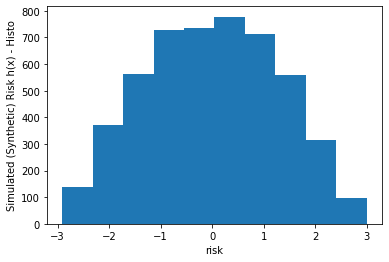

In [50]:
import matplotlib.pyplot as plt
plt.hist(training_D['hr'])
#
plt.xlabel('risk')
plt.ylabel('Simulated (Synthetic) Risk h(x) - Histo')

In [52]:
## Transform into Pandas ---

DURATION_COL1 = 'Time'
EVENT_COL1 = 'Event'
tds_No_treat = format_dataset_to_df(training_D,
          DURATION_COL1, EVENT_COL1)

## --- To recommend options ...
EVENT_COL2 = 'e'
EVENT_COL3 = 5

tds_treat = format_dataset_to_df(training_D,
          DURATION_COL1, EVENT_COL2, EVENT_COL3)

tds_treat

,0,1,2,3,4,treat,Time,e,hr
0,0.392938,-0.427721,-0.546297,0.102630,0.438938,0.0,100.000000,0,-0.441273
1,0.961528,0.369659,-0.038136,-0.215765,-0.313644,0.0,83.764580,1,1.722079
2,-0.122856,-0.880644,-0.203911,0.475991,-0.635017,0.0,100.000000,0,-1.862912
3,0.063103,0.063655,0.268802,0.698864,0.448911,1.0,0.585645,1,0.211645
4,0.444887,-0.354082,-0.276423,-0.543474,-0.412572,0.0,37.641518,1,-0.242046
...,...,...,...,...,...,...,...,...,...
4995,0.025973,-0.266009,-0.411932,0.505815,0.631917,0.0,29.822063,1,-0.484812
4996,-0.535541,-0.168888,0.134322,0.881657,0.085305,1.0,0.339474,1,-0.852086
4997,-0.219249,0.096418,-0.063370,0.903171,-0.831407,0.0,100.000000,0,-0.005182
4998,0.357314,0.269267,-0.214868,-0.453897,-0.045454,1.0,1.255109,1,0.917079


Text(0, 0.5, 'Risk h(x) - PDF')

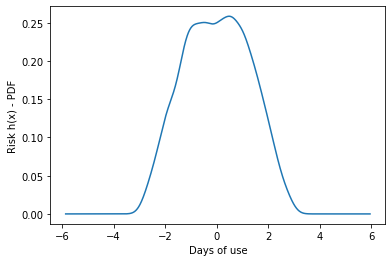

In [53]:
tds_treat['hr'].plot(kind='density')
#
plt.xlabel('Days of use')
plt.ylabel('Risk h(x) - PDF')

Text(0, 0.5, 'time - PDF')

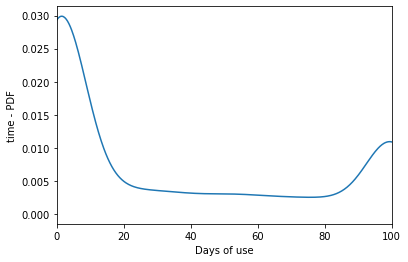

In [54]:
tds_treat['Time'].plot(kind='density')
plt.xlim(0,end_time)
plt.xlabel('Days of use')
plt.ylabel('time - PDF')

---
---
# Visual of the Simulation:

/Users/josem/PycharmProjects/HelloJasper_2022/venv/lib/python3.8/site-packages/lifelines/plotting.py:723: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


Observed engagement at time 100:
 [1.0000000e+02 8.3764580e+01 1.0000000e+02 5.8564544e-01 3.7641518e+01
 5.2713600e+01 1.4636045e+00 5.8271908e+01 8.3472733e+01 1.0000000e+02
 1.0000000e+02 3.2303960e+00 9.4569273e-02 4.0365841e+01 1.4413966e-01
 8.2351106e-01 1.4672858e+00 1.7302133e+00 1.7077161e+00 1.0000000e+02
 1.0296201e+01 3.5138431e-01 1.0000000e+02 2.5866983e+01 3.4398598e+01
 3.9403975e-01 1.0000000e+02 1.2920940e-01 8.2049215e-01 1.0750806e+01
 2.4314263e+00 3.8491365e-01 3.9771530e+01 7.8114185e+00 1.0000000e+02
 1.0000000e+02 4.3879814e+00 4.7604866e+00 1.1711207e-01 8.1829816e-01
 5.9708092e+01 1.0030102e+00 1.1427263e-01 1.0000000e+02 1.2481096e+00]


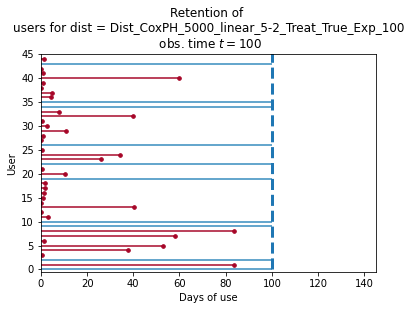

In [55]:
# One different way to see this:
from lifelines.plotting import plot_lifetimes

x1 = training_D['t'][:45]
CURRENT_TIME = end_time
fileSimul1=\
f'/Dist_CoxPH_{Nsample}_{method}_{num_features}-{num_var}_Exp_{end_time}_Simul_v1.png'

fileSimulName=\
f'Dist_CoxPH_{Nsample}_{method}_{num_features}-{num_var}_Treat_{option_group}_Exp_{end_time}'
# for dist = 1
observed_lifetimes1 = x1 #np.minimum(x1, CURRENT_TIME)
retention_observed1 = x1 < CURRENT_TIME
# for dist = 2
#observed_lifetimes2 = x2
#retention_observed2 = x2 < CURRENT_TIME

# Let's plot the traffic ...
ax = plot_lifetimes(observed_lifetimes1,
                    event_observed=retention_observed1,
                    sort_by_duration=False)

ax.set_xlim(0, end_time+45)
ax.vlines(CURRENT_TIME, 0, Nsample, lw=3, linestyles='--')

# Labels ...
ax.set_xlabel('Days of use')
ax.set_ylabel('User')

ax.set_title("Retention of \n"
     "users for dist = "
     +str(fileSimulName)+"\n"
     " obs. time $t="+str(CURRENT_TIME)+"$")
print("Observed engagement at time %d:\n" % (CURRENT_TIME), observed_lifetimes1)

fig = ax.get_figure()
fig.savefig('./'+fileSimul1)

In [57]:
#tds_treat[(tds_treat['e']==0)]

In [58]:
# With SurPyVal
import surpyval as surv

# Has an important influence in the survival curve
lamb2 = 9.
# ------------------------------------------------
k2 = 1.6

## - Our data
x1=np.array(pd.DataFrame(training_D['t'])[0])
c1=np.array(pd.DataFrame(training_D['e'])[0])

## -- From SurvPy - No correlation
x11 = surv.Weibull.random(Nsample, lamb2, k2)

x11.shape, x1.shape,type(x11), c1.shape

((5000,), (5000,), numpy.ndarray, (5000,))

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Parameters          :
     alpha: 16.736947061313074
      beta: 0.4793935803317412


<AxesSubplot:title={'center':'Weibull Probability Plot'}, ylabel='CDF'>

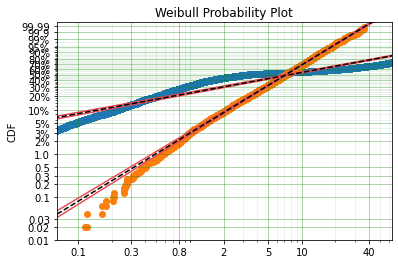

In [59]:
model1 = surv.Weibull.fit(x=x1)
model3 = surv.Weibull.fit(x=x11)

print(model1)

model1.plot()
model3.plot()

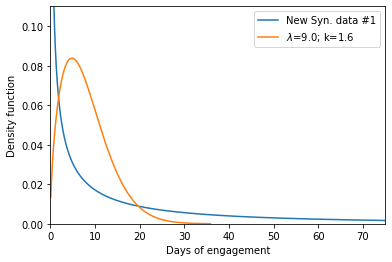

In [60]:
# We can model the density of the distribution
from numpy import random
from numpy.random import uniform, exponential

# - Start of the observation
nStart = 0.1

# Study for one month...
nEnd = 150. # 5 months

# - Number of users for the simulation ...
nPoints = Nsample
x1D=np.sort(x1)
x3D=np.sort(x11)

# - Aqui asumiendo que las tres son Weinbull, lo cual
# no es correcto!

f1 = model1.df(x1D)
f3 = model3.df(x3D)


plt.plot(x1D, f1, label='New Syn. data #1')

plt.plot(x3D, f3,
         label='$\lambda$='+str(lamb2)+'; k='+str(k2))
# ----
plt.legend(loc='best')

plt.xlabel('Days of engagement')
plt.ylabel('Density function')
plt.xlim(0,75)
plt.ylim(0,0.11)

# Name
fileDist11 = './report_2023/'
fileDist1 = fileDist11+'SynDist_1.png'
plt.savefig(fileDist1)

---
# Storing data

In [61]:
from os.path import exists

# Comparison of 4 S(t) functions
kL=[0.2, 0.5, 1.5, 3.5]
lamb1=10
#
fmt = 'csv'

filename = \
f'./Synthe_Data_v1/Synthetic_CoxPH_{Nsample}_{method}_{num_features}-{num_var}_Options_{option_group}_Exp_{end_time}_v1.{fmt}'

## We save the data with correlation
print('Cox PH Synthetic data stored in:', filename)

if not exists(filename):
    if option_group == False:
        tds_No_treat.to_csv(filename)
    else:
        tds_treat.to_csv(filename)

Cox PH Synthetic data stored in: ./Synthe_Data_v1/Synthetic_CoxPH_5000_linear_5-2_Options_True_Exp_100_v1.csv


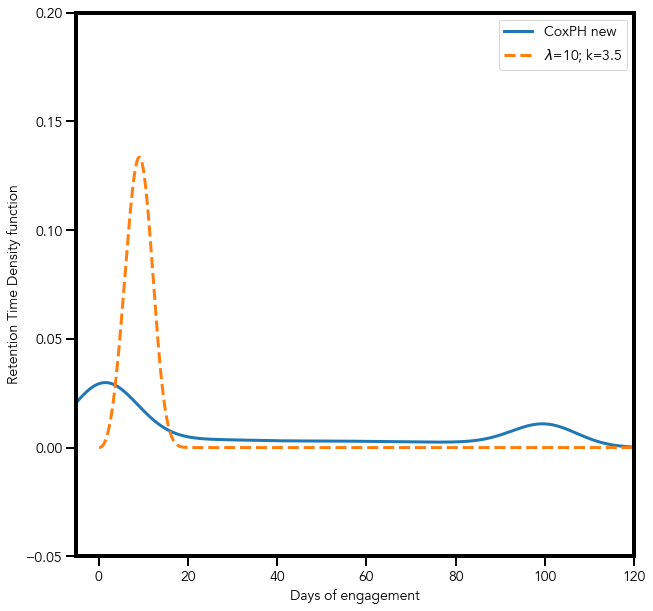

<Figure size 720x720 with 0 Axes>

In [64]:
#
# With SurPyVal
#import surpyval as surv
putStyle(14, 2, True, True)


kL=[0.2, 0.5, 1.5, 3.5]
lamb1=10

fmt = 'csv'
filename1 = filename


# - Start of the observation
nStart = 0.1
# Study for one month...
nEnd = 150.
nPoints=nPoints

x11 = np.linspace(nStart, nEnd, nPoints)
x11=np.sort(x11)

i1=1
for i,k1 in enumerate(kL[3:4]):
    # Testing loading
    See1=filename1

    dfPlot1 = pd.read_csv(See1).dropna()
    #
    xPlot=surv.Weibull.random(nPoints,lamb1,k1)
    modelPlot = surv.Weibull.fit(xPlot)

    fPlot = modelPlot.df(x11)

    dfPlot1['Time'].plot(kind='density',label='CoxPH new')
#
    plt.plot(x11, fPlot,'--',
             label='$\lambda$='+str(lamb1)+'; k='+str(k1))

plt.legend(loc='best')
plt.xlabel('Days of engagement')
plt.ylabel('Retention Time Density function')

plt.xlim(-5,120)
plt.ylim(-0.05,0.2)
plt.show()
plt.savefig('RetTime_CoxPH_From_FilesCSV_v2.png')

0 ./Synthe_Data_v1/Synthetic_CoxPH_5000_linear_5-2_Options_True_Exp_100_v1.csv


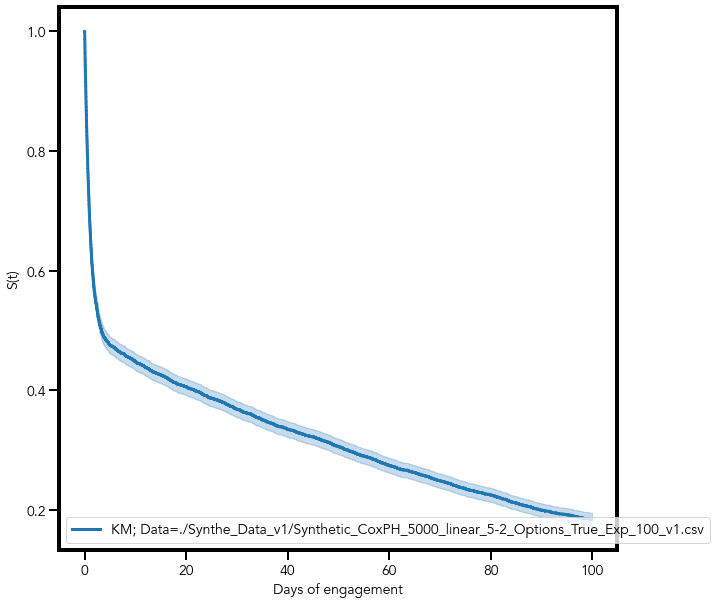

In [65]:
# Survival curves
from lifelines import KaplanMeierFitter
#putStyle(14, 2, True, True)
kL=[0.2, 0.5, 1.5, 3.5]
lamb1=10
fmt = 'csv'

filenames=[filename]

# - Start of the observation
nStart = 0.1
# Study for one month...
nEnd = 150.
nPoints=nPoints

x11 = np.linspace(nStart, nEnd, nPoints)
x11=np.sort(x11)

for i,k1 in enumerate(filenames):
    print(i,k1)
    dfPlot = pd.read_csv(k1).dropna()
    dfPlot.head()
    if i==0:
        xPlot=dfPlot['Time']
    elif i==1:
        xPlot=dfPlot['time']*30
    elif i==2:
        xPlot=dfPlot['Stime']

    retention_observed1 = xPlot < end_time
    #print(retention_observed1[:5])
    ## create a kmf object
    kmf = KaplanMeierFitter()
    ## Fit the data into the model
    kmf.fit(xPlot, retention_observed1,
                label='KM'+'; Data='+str(k1))

    ## Create an estimate
    kmf.plot(ci_show=True) ## ci_show is meant for Confidence interval

#plt.legend(loc='best')
plt.xlabel('Days of engagement')
plt.ylabel('S(t)')

#plt.xlim(-5,710)
#plt.ylim(-0.05,0.37)
#plt.show()
plt.savefig('CompaAll_CoxPH_From_FilesCSV_v2.png')

---
---
# Now Modelling

In [67]:
hyperparams2 = {
    "L2_reg": 9.72212890625, "dropout": 0.00884765625000001, "learning_rate": 0.0026024993217560365,
    "lr_decay": 0.00016355468750000002, "momentum": 0.845416015625, "batch_norm": False, "activation": "selu",
    "standardize": True, "n_in": (training_D['x'].shape[1]), "hidden_layers_sizes": [55]
}

In [68]:
# Create an instance of DeepSurv using the hyperparams
# defined above
model2 = deep_surv.DeepSurv(**hyperparams2)

In [69]:
# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines:
# logger = None

experiment_name = 'test_experiment_HJ'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn2 = lasagne.updates.adam  # The type of optimizer to use. \
# Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \

# for other optimizers to use
n_epochs = 100

# If you have validation data, you can add it as the second parameter to the function
#metrics = {}
metrics2 = model2.train(training_D,
                        valid_D,
                        n_epochs=n_epochs,
                        logger=logger, update_fn=update_fn2)

2023-01-17 18:27:10,043 - Training step 0/100   |                         | - loss: 19.9546 - ci: 0.7498
2023-01-17 18:27:32,613 - Finished Training with 100 iterations in 23.59s


Train C-Index: (99, 0.7572436441129002)
Valid C-Index:  (0, 0.750447583258823)


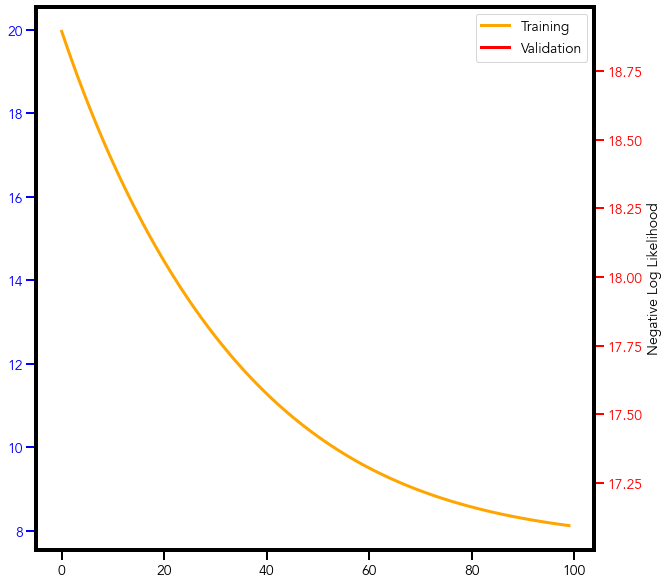

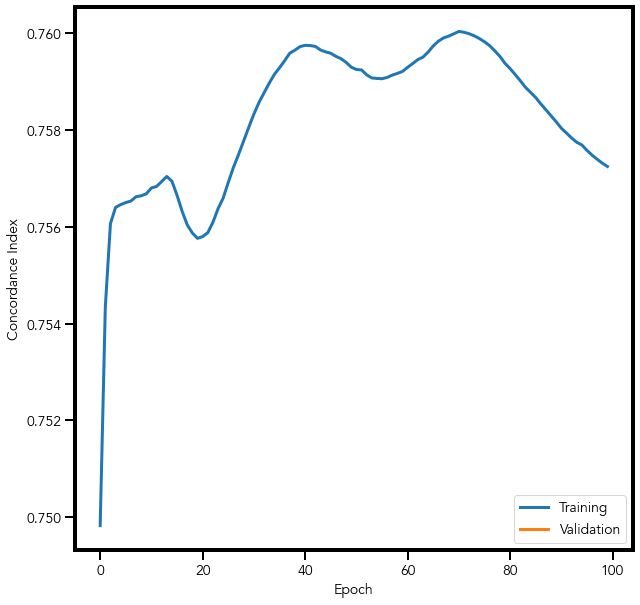

In [70]:
# Print the final metrics
print('Train C-Index:', metrics2['c-index'][-1])
print('Valid C-Index: ', metrics2['valid_c-index'][-1])

# Plot the training / validation curves
putStyle(14, 2, True, True)

fig1 = fileDist11+'/Train_Deep2_v1.png'
fig2 = fileDist11+'/C-Stat_Deep2_v1.png'
viz.plot_log(metrics2, fig1, fig2)


In [71]:
def evaluate_model(model, dataset, bootstrap = False):
    def mse(model):
        def deepsurv_mse(x, hr, **kwargs):
            hr_pred = np.squeeze(model.predict_risk(x))
            return ((hr_pred - hr) ** 2).mean()

        return deepsurv_mse

    metrics = {}

    # Calculate c_index
    metrics['c_index'] = model.get_concordance_index(**dataset)
    if bootstrap:
        metrics['c_index_bootstrap'] = utils.bootstrap_metric(model.get_concordance_index, dataset)

    # Calculate MSE
    if 'hr' in dataset:
        metrics['mse'] = mse(model)(**dataset)
        if bootstrap:
            metrics['mse_bootstrap'] = utils.bootstrap_metric(mse(model), dataset)

    return metrics

def save_risk_surface_visualizations(model, dataset, norm_vals, output_dir, plot_error, experiment,
    trt_idx):
    if experiment == 'linear':
        clim = (-3,3)
    elif experiment == 'gaussian' or experiment == 'treatment':
        clim = (-1,1)
    else:
        clim = (0,1)

    risk_fxn = lambda x: np.squeeze(model.predict_risk(x))
    color_output_file = os.path.join(output_dir, "deep_viz_color_" + TIMESTRING + ".pdf")
    viz.plot_experiment_scatters(risk_fxn, dataset, norm_vals = norm_vals,
        output_file=color_output_file, figsize=(4,3), clim=clim,
        plot_error = plot_error, trt_idx = trt_idx)

    bw_output_file = os.path.join(output_dir, "deep_viz_bw_" + TIMESTRING + ".pdf")
    viz.plot_experiment_scatters(risk_fxn, dataset, norm_vals = norm_vals,
        output_file=bw_output_file, figsize=(4,3), clim=clim, cmap='gray',
        plot_error = plot_error, trt_idx = trt_idx)


def save_treatment_rec_visualizations(model, dataset, output_dir,
    trt_i = 1, trt_j = 0, trt_idx = 0):

    trt_values = np.unique(dataset['x'][:,trt_idx])
    print("Recommending options:", trt_values)
    rec_trt = model.recommend_treatment(dataset['x'], trt_i, trt_j, trt_idx)
    rec_trt = np.squeeze((rec_trt < 0).astype(np.int32))

    rec_dict = utils.calculate_recs_and_antirecs(rec_trt, true_trt = trt_idx, dataset = dataset)

    output_file = os.path.join(output_dir, '_'.join(['deepsurv',TIMESTRING, 'rec_surv.pdf']))
    print(output_file)
    viz.plot_survival_curves(experiment_name = 'DeepSurv', output_file=output_file, **rec_dict)

def save_model(model, output_file):
    model.save_weights(output_file)


Saving Visualizations Of OUR DATA ... 


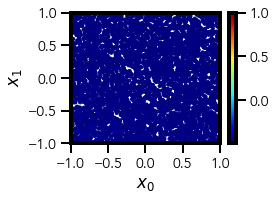

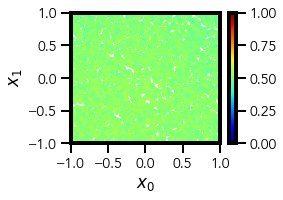

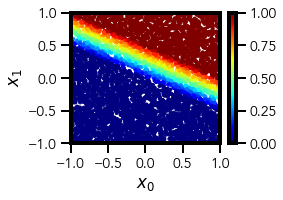

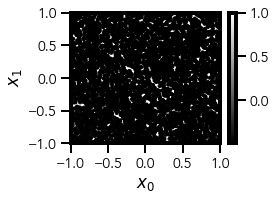

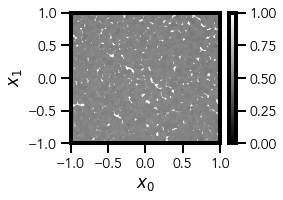

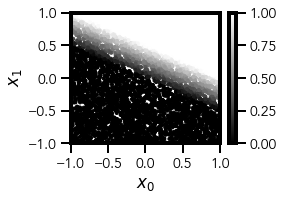

In [72]:
# --- Norm es importante --
norm_vals2 = {
        'mean' : training_D['x'].mean(axis =0),
        'std'  : training_D['x'].std(axis=0)
    }

print("Saving Visualizations Of OUR DATA ... ")
save_risk_surface_visualizations(
    model2,
    training_D, norm_vals=norm_vals2,
    output_dir=fileDist11, plot_error=False,
    experiment='deep_surv', trt_idx=5)

plt.savefig(fileDist11+'One_Plot.png')